In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
from subprocess import check_output
print(check_output(["ls", "data"]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv



# Introduction of Data
* **orders** : 모든 주문(prior/train/test)에 대한 정보, user_id를 기준으로 정렬되어 있음.
* **order_products__prior** : orders데이터에서 (eval_set = prior)인 데이터, 하나의 주문(order_id)을 구성하는 제품 정보(product_id 등)
* **order_products__train** : orders데이터에서 (eval_set = train)인 데이터, 내용은 prior와 같음.
* **products** : 제품 정보
* **aisles** : 제품(products)의 소분류
* **departments** : 제품(products)의 대분류
* products < aisles < departments
## orders 데이터 중 (eval_set = test) 인 주문을 구성하는 제품 정보(product_id)를 맞춰라!

In [3]:
order_products_train = pd.read_csv("data/order_products__train.csv")
order_products_prior = pd.read_csv("data/order_products__prior.csv")
orders = pd.read_csv("data/orders.csv")
products = pd.read_csv("data/products.csv")
aisles = pd.read_csv("data/aisles.csv")
departments = pd.read_csv("data/departments.csv")

## 1. orders
* **order_id** : 주문 번호
* **user_id** : 주문한 유저 id
* **eval_set** : 학습 및 평가를 위한 데이터 분류, prior/train/test로 구성
* **order_number** : 해당 유저에 대한 주문 순서의 넘버링, ex) 5일 경우 해당 유저의 5번째 주문
* **order_dow** : 주문한 요일(0-6), dow=day_of_week
* **order_hour_of_day** : 하루 24시간 중 주문한 시각(0-23)
* **days_since_prior_order** : [현재 주문 시점 - 직전 주문 시점], 얼마만에 주문하였는가

In [4]:
print("The orders size is : ", len(orders))
orders.head(5)

The orders size is :  3421083


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [5]:
grouped = orders.groupby("eval_set")["order_id"].aggregate({'Total_orders': 'count'}).reset_index()
grouped['Ratio'] = grouped["Total_orders"].apply(lambda x: x /grouped['Total_orders'].sum())
grouped

/Users/Joohong/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  if __name__ == '__main__':


,eval_set,Total_orders,Ratio
0,prior,3214874,0.939724
1,test,75000,0.021923
2,train,131209,0.038353


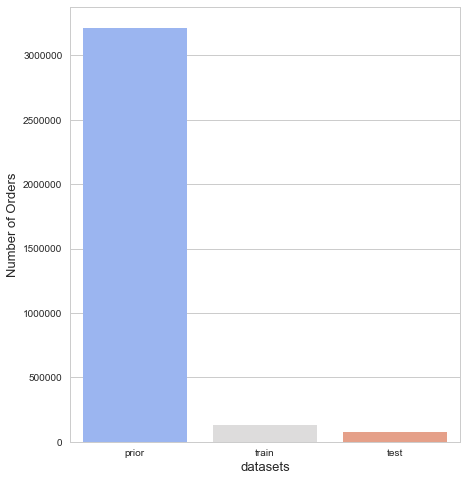

In [6]:
grouped  = grouped.groupby(['eval_set']).sum()['Total_orders'].sort_values(ascending=False)

sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(7, 8))
sns.barplot(grouped.index, grouped.values, palette='coolwarm')
plt.ylabel('Number of Orders', fontsize=13)
plt.xlabel('datasets', fontsize=13)
plt.show()

## 2. order_products_prior
* **order_id** : 주문 번호, orders와 공유
* **product_id** : 제품 번호, 하나의 주문은 여러 개의 제품으로 구성됨.
* **add_to_cart_order** : 장바구니에 들어간 순서
* **reordered** : 재구매(이전에 구매한 적이 있는지) 여부, [0:첫구매 / 1:재구매]

In [7]:
print("The order_products_prior size is : ", len(order_products_prior))
order_products_prior.head(5)

The order_products_prior size is :  32434489


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


## 3. order_products_train
* order_products_prior와 동일한 Attribute로 구성

In [8]:
print("The order_products_train size is : ", len(order_products_train))
order_products_train.head(5)

The order_products_train size is :  1384617


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


## Extra) order_products_all
* order_products_prior + order_products_train

In [9]:
order_products_all = pd.concat([order_products_train, order_products_prior], axis=0)
print("The order_products_all size is : ", len(order_products_all))
order_products_all.head(5)

The order_products_all size is :  33819106


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


Check Unique Orders and ordered Products

In [10]:
# Check the number of unique orders and unique products
orders_Unique = len(order_products_all.order_id.unique())
products_Unique = len(order_products_all.product_id.unique())
print("There are %s orders for %s products" %(orders_Unique, products_Unique))

There are 3346083 orders for 49685 products


## 4. products
* **product_id** : 제품 번호
* **product_name** : 제품명
* **aisle_id** : 소분류 id
* **department_id** : 대분류 id

In [11]:
print("The products size is : ", len(products))
products.head(5)

The products size is :  49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


## 5. aisles
* **aisle_id** : 소분류 id
* **aisle** : 소분류 이름

In [12]:
print("The aisles size is : ", len(aisles))
aisles.head(5)

The aisles size is :  134


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


## 6. departments
* **department_id** : 대분류 id
* **department** : 대분류 이름

In [13]:
print("The departments size is : ", len(departments))
departments.head(5)

The departments size is :  21


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


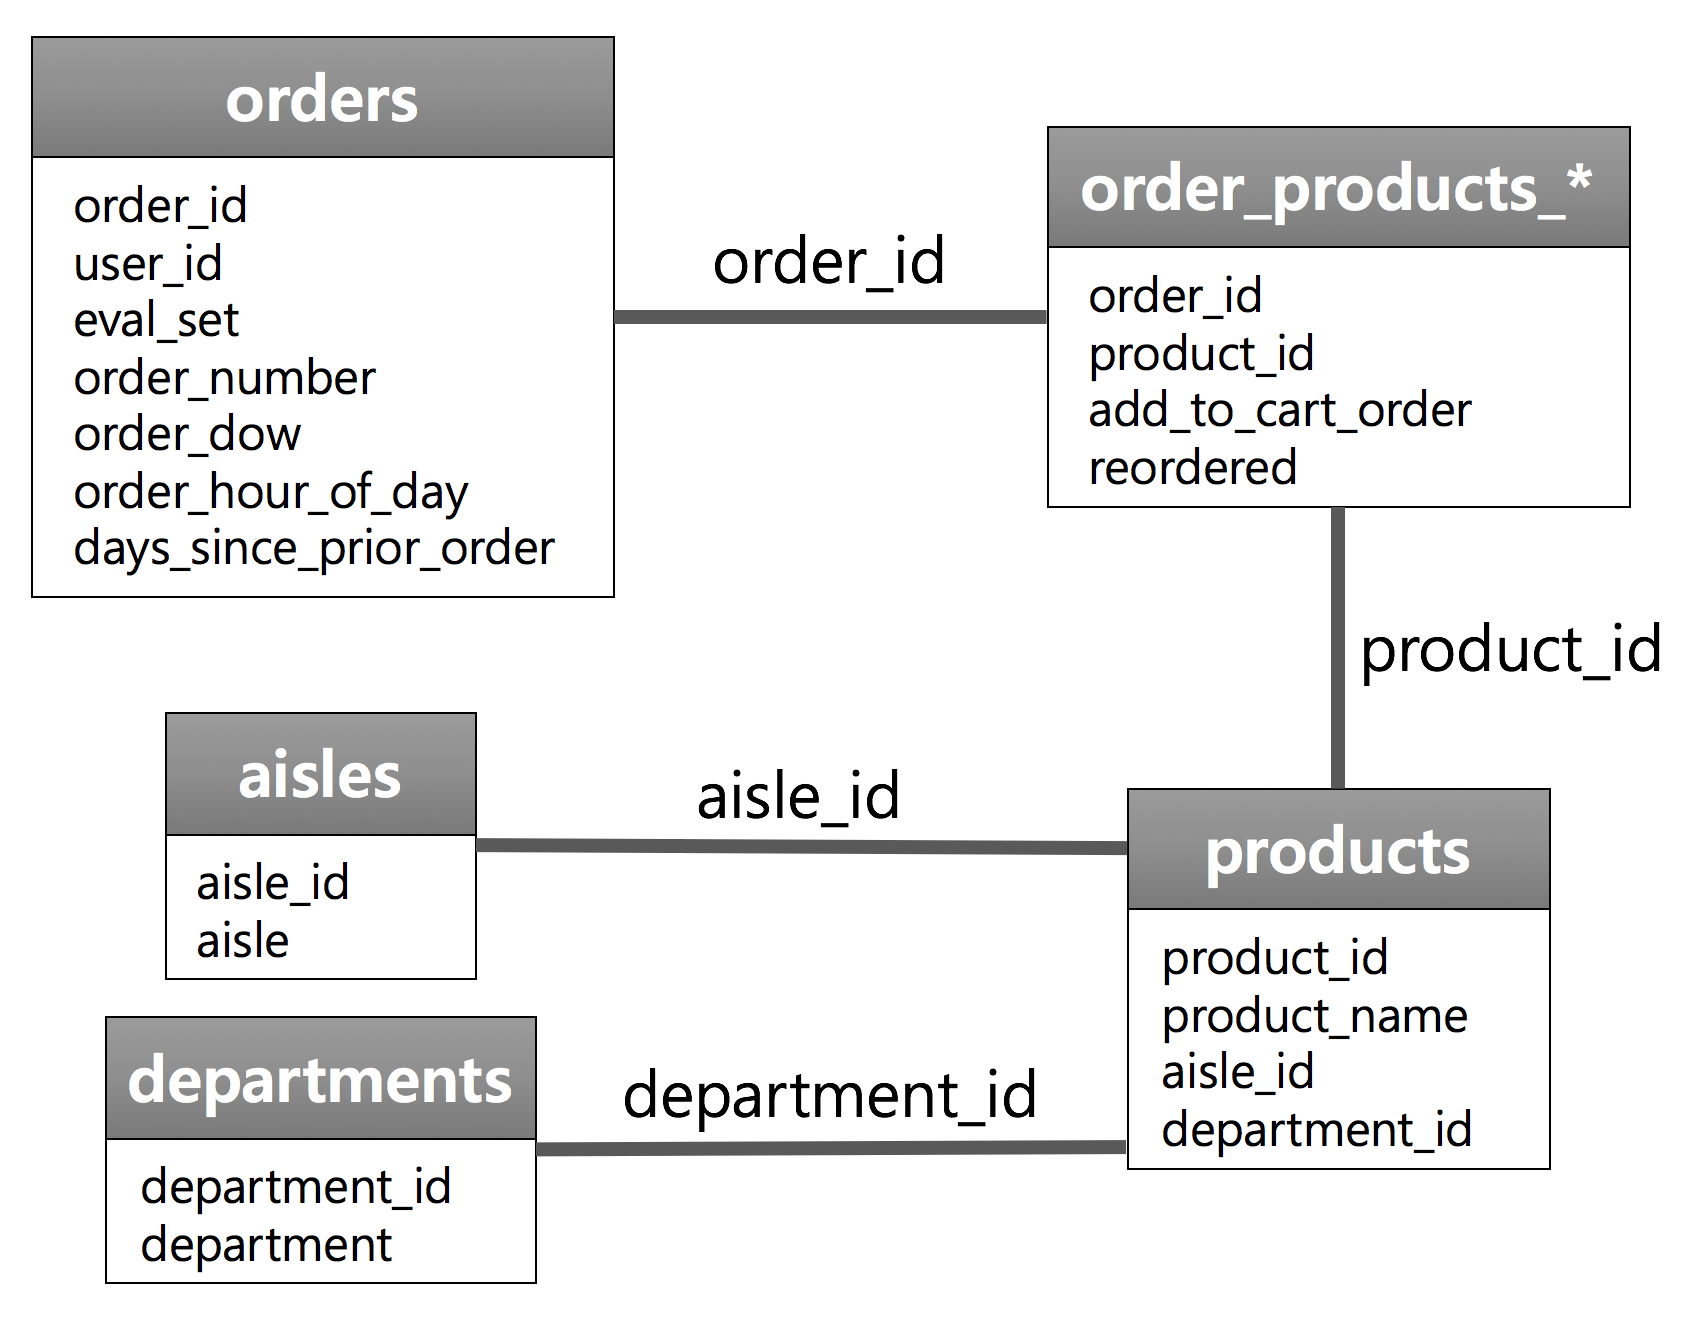

In [14]:
from IPython.display import Image
Image("img/data_diagram.png")